# Evaluation of Word Vector Embeddings

In [1]:
# Standard libraries
import json
import random
import itertools

# Third-party libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from gensim.models import Word2Vec

# Load utility functions
from utils import *

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/fabianbeigang/nltk_data...
[nltk_data]   Package wordnet is already up-t

### 0. Load models and vocabulary

In [2]:
# Load models
model_se_trusted = Word2Vec.load("models/word2vec_with_bigrams_se_trusted_300_6.model")
model_pseudoscience = Word2Vec.load("models/word2vec_with_bigrams_pseudoscience_300_6.model")

In [3]:
# Load bigram_transformer vocab
with open('data/bigram_transformer_vocab.json', 'r') as f:
    bigram_transformer_vocab = json.load(f)

### 1. Manual inspection of relevant terms

In [4]:
# Find closest words
df_test = find_closest_words(model_se_trusted, "SE/Trusted", model_pseudoscience, "Pseudoscience", 'mask_mandate', top_n=20)
df_test

,SE/Trusted - Word,SE/Trusted - Score,Pseudoscience - Word,Pseudoscience - Score
0,reopen,0.676358,masking,0.688966
1,reopening,0.657180,lockdown,0.654656
2,lockdown,0.641958,school closure,0.638793
3,social distancing,0.608603,mask wearing,0.635916
4,masking,0.594307,mandate,0.622376
5,shutdown,0.587407,social distancing,0.602866
6,distancing,0.581785,mask,0.579048
7,mandate,0.580088,restriction,0.571981
8,mask wearing,0.575139,wear mask,0.561267
9,restriction,0.560316,face covering,0.554788


In [5]:
# Compare distance between words in both models
for pairs in [["vaccine","safe"],["vaccine", "adverse event"],["vaccine","optimistic"],["vaccine","blood clot"],["vaccine","bill gates"],["vaccine","death"],["government","scam"],["government","control"],["control","vaccine"],["bioweapon","vaccine"]]:
    similarity_dict = compare_words_in_models(model_se_trusted, "SE/Trusted", model_pseudoscience, "Pseudoscience", pairs[0], pairs[1])
    print_similarity_results(similarity_dict, pairs[0], pairs[1])
    print()

Similarity between 'vaccine' and 'safe':
In SE/Trusted: 0.1721
In Pseudoscience: 0.1717

Similarity between 'vaccine' and 'adverse event':
In SE/Trusted: 0.2372
In Pseudoscience: 0.3622

Similarity between 'vaccine' and 'optimistic':
In SE/Trusted: 0.1451
In Pseudoscience: 0.0499

Similarity between 'vaccine' and 'blood clot':
In SE/Trusted: 0.0767
In Pseudoscience: 0.2468

Similarity between 'vaccine' and 'bill gates':
In SE/Trusted: -0.0623
In Pseudoscience: 0.1292

Similarity between 'vaccine' and 'death':
In SE/Trusted: 0.1785
In Pseudoscience: 0.2997

One or both words not found in SE/Trusted.
Similarity between 'government' and 'scam':
In Pseudoscience: 0.2080

Similarity between 'government' and 'control':
In SE/Trusted: 0.0292
In Pseudoscience: 0.2134

Similarity between 'control' and 'vaccine':
In SE/Trusted: 0.0288
In Pseudoscience: 0.0581

One or both words not found in SE/Trusted.
Similarity between 'bioweapon' and 'vaccine':
In Pseudoscience: 0.2624



### 2. Visualisation

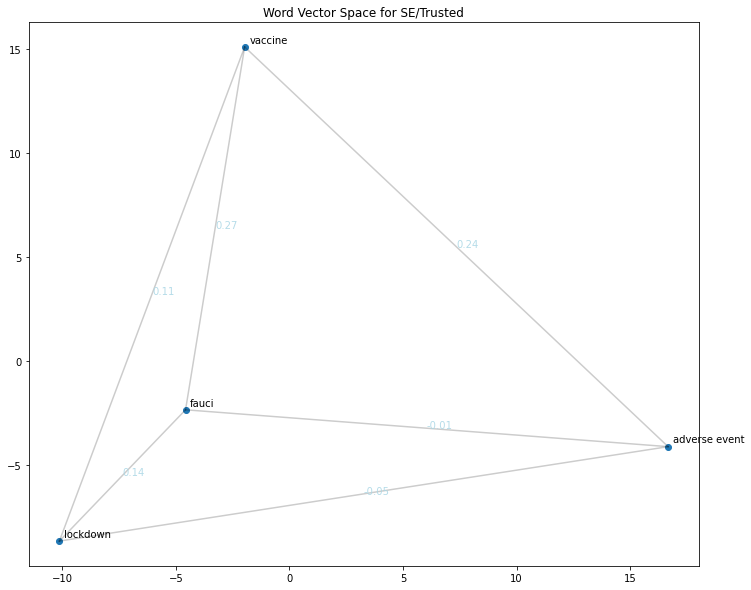

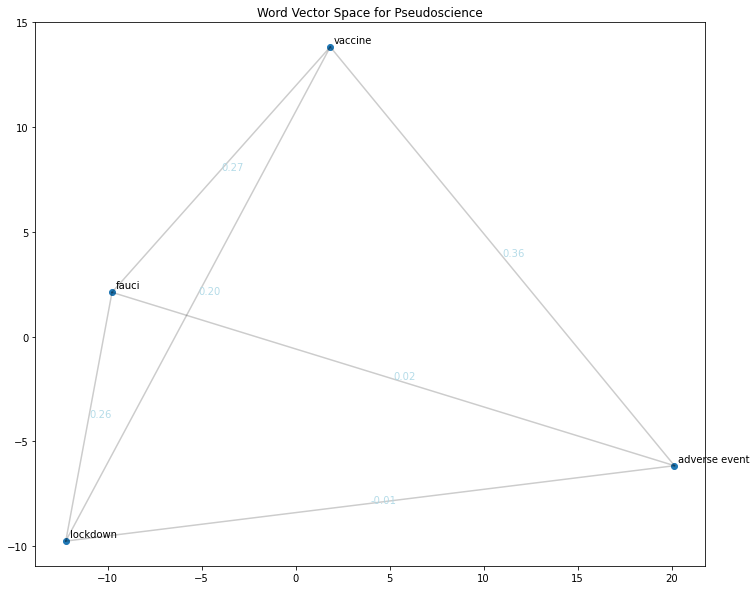

In [6]:
# Check if the words are in the vocabulary
words = ['lockdown', 'vaccine', 'adverse event','death','covid', 'healthcare','fauci','mask', 'mask mandate','epidemic', 'conspiracy']  # Replace 'adverse_event' with the actual token if different
words = ['lockdown', 'vaccine', 'adverse_event','fauci']

# Example use
plot_wv_pca(model_se_trusted, "SE/Trusted", model_pseudoscience, "Pseudoscience", words, show_distance=True)


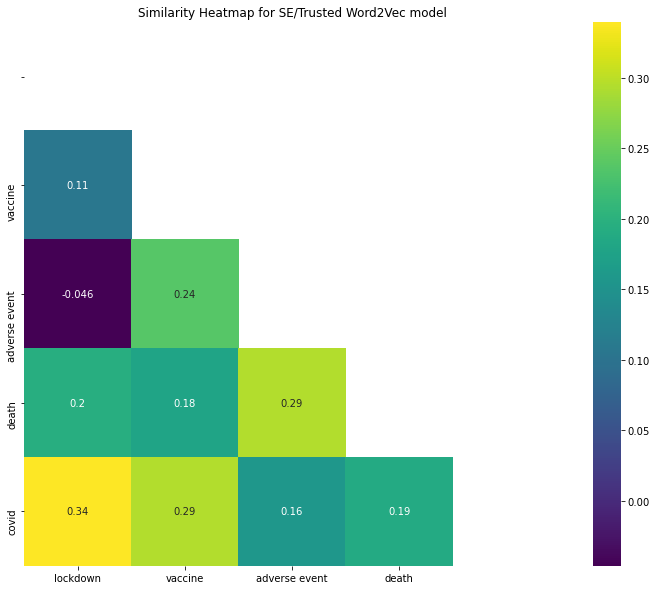

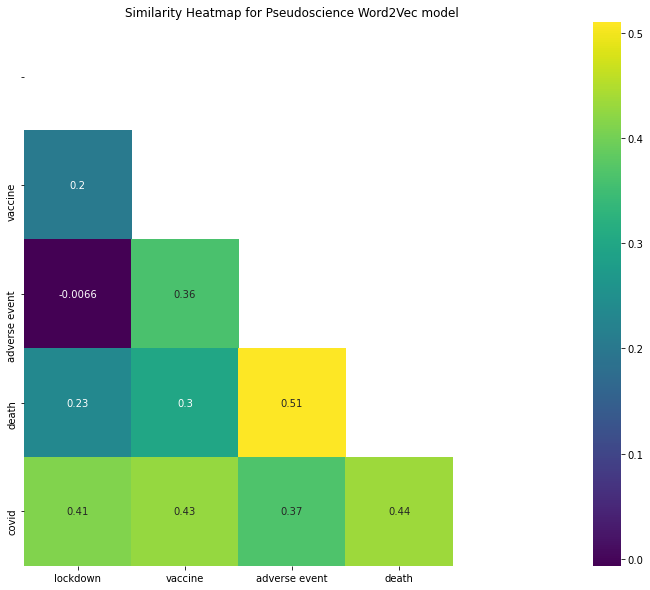

In [7]:
words = ['lockdown', 'vaccine', 'adverse_event', 'death','covid']
plot_wv_heatmap(model_se_trusted, "SE/Trusted", model_pseudoscience, "Pseudoscience", words)

### 3. Analyse the distribution of differences in similarity judgments between the two corpora

In [9]:
# Get the most common words in the combined corpora
n = 1000
most_common_words = [term for term in bigram_transformer_vocab.keys() if bigram_transformer_vocab[term] > n and not '_token' in term]
print(f"{len(most_common_words)} words with more than {n} occurrences in the combined corpora")

# Create a list of all pairwise combinations of words
word_combinations = list(itertools.combinations(most_common_words, 2))
print(f"{len(word_combinations)} word combinations")

# Calculate the similarity between each pair of words
similarity_dict = []

for i, pair in enumerate(word_combinations):
    try:
        row =  [pair,model_se_trusted.wv.similarity(pair[0], pair[1]), model_pseudoscience.wv.similarity(pair[0], pair[1])]
        similarity_dict.append(row)
    except:
        pass

# Convert the list to a dataframe
similarity_df = pd.DataFrame(similarity_dict, columns=["pair","SE/Trusted","Pseudoscience"])

# Add columns
similarity_df["Difference (SE-Pseudo)"] = similarity_df["SE/Trusted"] - similarity_df["Pseudoscience"]
similarity_df["Abs. Difference"] = similarity_df["Difference (SE-Pseudo)"].apply(lambda x: abs(x))
similarity_df = similarity_df.sort_values(by="Abs. Difference", ascending=False)
similarity_df["SE > Pseudo"] = similarity_df["Difference (SE-Pseudo)"] > 0
similarity_df

8566 words with more than 1000 occurrences in the combined corpora
36683895 word combinations


,pair,SE/Trusted,Pseudoscience,Difference (SE-Pseudo),Abs. Difference,SE > Pseudo
22994647,"(cole, rhode)",0.639446,-0.056929,6.963750e-01,6.963750e-01,True
10249108,"(heartburn, lastly)",-0.323737,0.363378,-6.871151e-01,6.871151e-01,False
22992770,"(msm, mainstream_medium)",0.004672,0.687533,-6.828609e-01,6.828609e-01,False
21521543,"(melinda_gate, electronic_signature)",0.625896,-0.039738,6.656344e-01,6.656344e-01,True
19388536,"(buffer, pbs)",0.686671,0.021228,6.654438e-01,6.654438e-01,True
...,...,...,...,...,...,...
10263835,"(consumption, breakdown)",0.219592,0.219592,-2.980232e-08,2.980232e-08,False
14807933,"(register, pole)",-0.023902,-0.023902,-1.862645e-08,1.862645e-08,False
5222064,"(correct, manufacturing_process)",0.119118,0.119118,-7.450581e-09,7.450581e-09,False
12850178,"(marketing, unpleasant)",-0.086121,-0.086121,7.450581e-09,7.450581e-09,True


In [10]:
similarity_df.sort_values(by="Pseudoscience", ascending=False)

,pair,SE/Trusted,Pseudoscience,Difference (SE-Pseudo),Abs. Difference,SE > Pseudo
10290299,"(milligrams, milligram)",0.902295,0.896253,0.006042,0.006042,True
18959389,"(teaspoon, tablespoon)",0.885560,0.895828,-0.010268,0.010268,False
13449449,"(june, july)",0.912487,0.894288,0.018199,0.018199,True
22032281,"(vata, kapha)",0.865907,0.893984,-0.028076,0.028076,False
13753774,"(august, july)",0.900425,0.879698,0.020727,0.020727,True
...,...,...,...,...,...,...
2301908,"(mean, taylor)",-0.253467,-0.416285,0.162817,0.162817,True
2300658,"(mean, louis)",-0.251040,-0.416526,0.165486,0.165486,True
2302209,"(mean, kelly)",-0.213479,-0.417192,0.203713,0.203713,True
6760173,"(want, vol)",-0.338910,-0.420747,0.081837,0.081837,True


In [11]:
similarity_df.sort_values(by="SE/Trusted", ascending=False)

,pair,SE/Trusted,Pseudoscience,Difference (SE-Pseudo),Abs. Difference,SE > Pseudo
21505766,"(bill_melinda, gates_foundation)",0.933525,0.795942,0.137583,0.137583,True
13449449,"(june, july)",0.912487,0.894288,0.018199,0.018199,True
2452026,"(inform_consent, informed_consent)",0.912398,0.810332,0.102066,0.102066,True
21505773,"(bill_melinda, gate_foundation)",0.911158,0.763672,0.147485,0.147485,True
19368380,"(republicans, democrats)",0.909651,0.781271,0.128380,0.128380,True
...,...,...,...,...,...,...
12173238,"(furthermore, chase)",-0.440791,-0.199313,-0.241478,0.241478,False
17702589,"(respected, residual)",-0.444083,-0.182909,-0.261175,0.261175,False
6807026,"(addition, hell)",-0.446089,-0.341136,-0.104953,0.104953,False
1017100,"(integration, accidentally)",-0.450390,-0.200713,-0.249677,0.249677,False


In [12]:
# Show first rows
similarity_df.head(50)

,pair,SE/Trusted,Pseudoscience,Difference (SE-Pseudo),Abs. Difference,SE > Pseudo
22994647,"(cole, rhode)",0.639446,-0.056929,0.696375,0.696375,True
10249108,"(heartburn, lastly)",-0.323737,0.363378,-0.687115,0.687115,False
22992770,"(msm, mainstream_medium)",0.004672,0.687533,-0.682861,0.682861,False
21521543,"(melinda_gate, electronic_signature)",0.625896,-0.039738,0.665634,0.665634,True
19388536,"(buffer, pbs)",0.686671,0.021228,0.665444,0.665444,True
23049796,"(eddy, russians)",0.404297,-0.254366,0.658663,0.658663,True
15896002,"(indigestion, lastly)",-0.306083,0.345691,-0.651775,0.651775,False
22989157,"(rep, mortal)",0.603653,-0.046156,0.649810,0.649810,True
10432485,"(broccoli, brussels)",0.631270,-0.014444,0.645714,0.645714,True
22986279,"(celery, brussels)",0.588650,-0.052924,0.641573,0.641573,True


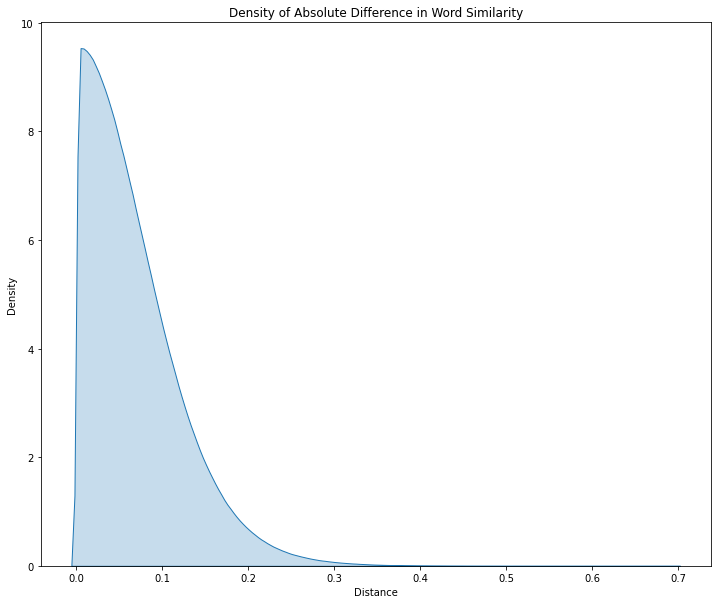

In [13]:
# Set figsize
plt.figure(figsize=(12,10))

sns.kdeplot(similarity_df['Abs. Difference'], fill=True)
plt.title('Density of Absolute Difference in Word Similarity')
plt.xlabel('Distance')
plt.show()


In [14]:
# Get median and IQR
median = similarity_df["Abs. Difference"].median()
q1 = similarity_df["Abs. Difference"].quantile(0.25)
q3 = similarity_df["Abs. Difference"].quantile(0.75)
iqr = q3 - q1

# Print
print(f"Median: {median:.3f}")
print(f"IQR: {iqr:.3f}")
print(f"Q1: {q1:.3f}")
print(f"Q3: {q3:.3f}")

Median: 0.057
IQR: 0.072
Q1: 0.027
Q3: 0.098


In [15]:
# Calculate the percentage of distances under 0.1 and over 0.5
percent_under_0_0_5 = (similarity_df["Abs. Difference"] < 0.05).mean() * 100
percent_under_0_1 = (similarity_df["Abs. Difference"] < 0.1).mean() * 100
percent_over_0_5 = (similarity_df["Abs. Difference"] > 0.5).mean() * 100

# Print
print(f"For {percent_under_0_0_5:.2f}% of word pairs, the difference between the two models is less than 0.05")
print(f"For {percent_under_0_1:.2f}% of word pairs, the difference between the two models is less than 0.1")
print(f"For {percent_over_0_5:.2f}% of word pairs, the difference between the two models is more than 0.5")

For 44.98% of word pairs, the difference between the two models is less than 0.05
For 75.80% of word pairs, the difference between the two models is less than 0.1
For 0.00% of word pairs, the difference between the two models is more than 0.5


### 4. Comparison of closest neighbour similarity 

In [16]:
# Of the terms that appear at least n=1000 times, choose 1000 randomly
random.seed(123)
random_words = random.sample(most_common_words, 1000)

# Display first 10
print(random_words[:10])

['new_vaccine', 'people_find', 'contagious', 'confusing', 'absolutely', 'bit', 'center', 'succeed', 'irregular', 'anemia']


In [17]:
# Create a list to store the data
structured_data = []

# Loop over the words
for word in random_words: 
    data = {"query_word": word}
    model_choice = random.choice(["SE/Trusted", "Pseudoscience"])

    try:
        # Get the most similar word and distance for the chosen model
        if model_choice == "SE/Trusted":
            most_similar_word, chosen_model_similarity = model_se_trusted.wv.most_similar(word)[0]
            other_model_similarity = model_pseudoscience.wv.similarity(word, most_similar_word)
        else:
            most_similar_word, chosen_model_similarity = model_pseudoscience.wv.most_similar(word)[0]
            other_model_similarity = model_se_trusted.wv.similarity(word, most_similar_word)

        # Store data
        data.update({
            "most_similar": most_similar_word,
            "word_source": model_choice,
            "similarity_in_source_model": chosen_model_similarity,
            "similarity_in_other_model": other_model_similarity,
        })

    except:
        # If the word is not in the vocabulary of one or both models
        data.update({"error": "Not in vocabulary of one or both models"})

    structured_data.append(data)

# Print first three rows
structured_data[:3]

[{'query_word': 'new_vaccine',
  'error': 'Not in vocabulary of one or both models'},
 {'query_word': 'people_find',
  'error': 'Not in vocabulary of one or both models'},
 {'query_word': 'contagious',
  'most_similar': 'highly_contagious',
  'word_source': 'Pseudoscience',
  'similarity_in_source_model': 0.6652026772499084,
  'similarity_in_other_model': 0.75592095}]

In [18]:
# Calculating the differences in similarity judgments between the two models
differences = []
for entry in structured_data:
    if "error" not in entry:
        difference = abs(entry["similarity_in_source_model"] - entry["similarity_in_other_model"])
        differences.append(difference)

# Convert differences to a pandas Series
differences_series = pd.Series(differences)

# Print statistics
print(f"Median: {differences_series.median()}")
print(f"Q1: {differences_series.quantile(0.25)}")
print(f"Q3: {differences_series.quantile(0.75)}")

# Print proportion of differences under 0.1 and over 0.5
# Use the Series for comparison
print(f"Proportion of differences under 0.1: {(differences_series < 0.1).mean()}")
print(f"Proportion of differences over 0.5: {(differences_series > 0.5).mean()}")

Median: 0.0857124924659729
Q1: 0.03842694312334061
Q3: 0.15205243229866028
Proportion of differences under 0.1: 0.5609418282548476
Proportion of differences over 0.5: 0.008310249307479225


### 5. Valence

In [19]:
# Reading the file into a DataFrame
file_path = 'data/valence-NRC-VAD-Lexicon.txt'
df_valence = pd.read_csv(file_path, sep='\t', header=None, names=['Word', 'Value'])

# Display
df_valence.head()

,Word,Value
0,generous,1.0
1,love,1.0
2,very positive,1.0
3,magnificent,1.0
4,happily,1.0


In [20]:
# Drop rows where the Word is not a string
df_valence = df_valence[df_valence['Word'].apply(lambda x: isinstance(x, str))]
df_valence.head()


,Word,Value
0,generous,1.0
1,love,1.0
2,very positive,1.0
3,magnificent,1.0
4,happily,1.0


In [60]:
# Drop rows where the Word is not a string
df_valence = df_valence[df_valence['Word'].apply(lambda x: isinstance(x, str))]

# Calculate similarity to vaccine for each word
df_valence['Similarity to "vaccine" (Pseudoscience)'] = df_valence['Word'].apply(lambda x: similiarty_to_vaccine(x, model_pseudoscience))
df_valence['Similarity to "vaccine" (SE/Trusted)'] = df_valence['Word'].apply(lambda x: similiarty_to_vaccine(x, model_se_trusted))

# Handling NaN values
df_valence_clean = df_valence.dropna(subset=['Similarity to "vaccine" (Pseudoscience)', 'Similarity to "vaccine" (SE/Trusted)'])

# Reshaping the DataFrame
df_long = pd.melt(df_valence_clean, 
                  id_vars=['Word', 'Value'], 
                  value_vars=['Similarity to "vaccine" (Pseudoscience)', 'Similarity to "vaccine" (SE/Trusted)'],
                  var_name='Model', 
                  value_name='Similarity')

# Creating a binary variable for model type
df_long['Model_Type'] = df_long['Model'].map({'Similarity to "vaccine" (Pseudoscience)': 1, 'Similarity to "vaccine" (SE/Trusted)': 0})

# Creating the interaction term
df_long['Valence*Model'] = df_long['Value'] * df_long['Model_Type']

# Set independent variables
X = df_long[['Value', 'Model_Type', 'Valence*Model']]
X = sm.add_constant(X) 

# Set dependent variable
Y = df_long['Similarity']

# Fit the model
model = sm.OLS(Y, X).fit()

# Print the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Similarity   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     79.00
Date:                Wed, 13 Dec 2023   Prob (F-statistic):           1.03e-50
Time:                        12:05:32   Log-Likelihood:                 10811.
No. Observations:               15414   AIC:                        -2.161e+04
Df Residuals:                   15410   BIC:                        -2.158e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0553      0.004    -15.319

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Running a regression analysis investigating the similarity of words with different valence to "vaccine" in two different contexts, twe observe the following: The dependent variable, 'Similarity', measures how closely words are associated with "vaccine". The model accounts for only 1.5% of variance in these similarity scores (as indicated by the R Squared score). Within the context of search engine and trusted sources (SE/Trusted model), the effect of a word's valence on its similarity to "vaccine" is not statistically significant, as indicated by the small and insignificant coefficient (-0.0007, p = 0.908). In contrast, the interaction term (Valence*Model) is significant (-0.0913, p < 0.0001) and shows that in the Pseudoscience context, as words become more positively valenced, their similarity to "vaccine" decreases more markedly than in the SE/Trusted context. This confirms the suspicion that there is a difference in how positive words relate to "vaccine" between the two models, indicating semantic differences around the word "vaccine" in the two corpora.

<Figure size 1200x1000 with 0 Axes>

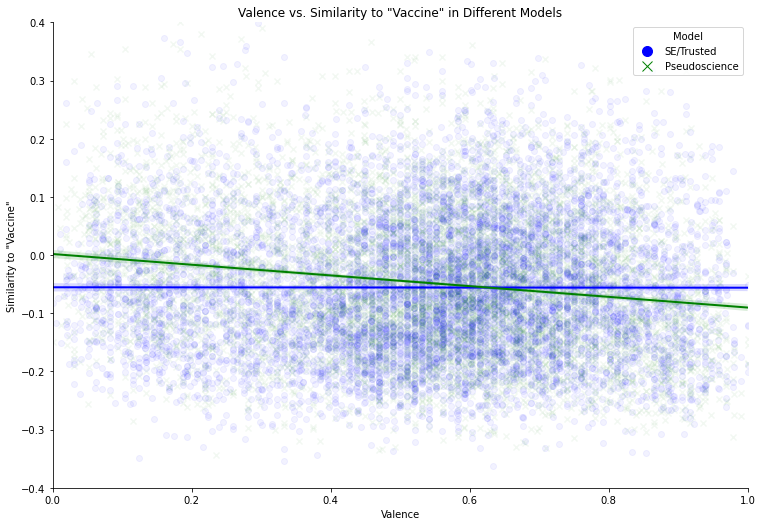

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

# Set figure size
plt.figure(figsize=(12, 10), dpi= 100)

# Create the lmplot with transparent scatter points
plot = sns.lmplot(x='Value', y='Similarity', hue='Model_Type', data=df_long,
                  palette=['blue', 'green'], markers=['o', 'x'],
                  scatter_kws={'alpha':0.05}, line_kws={'linewidth':2},
                  legend=False,  # Turn off the default legend
                  aspect=1.5, height=7)

plt.title('Valence vs. Similarity to "Vaccine" in Different Models')
plt.xlabel('Valence')
plt.ylabel('Similarity to "Vaccine"')
plt.ylim(-0.4, 0.4)

# Create custom legend handles and labels
legend_handles = [mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=10, label='SE/Trusted'),
                  mlines.Line2D([], [], color='green', marker='x', linestyle='None', markersize=10, label='Pseudoscience')]

plt.legend(handles=legend_handles, title='Model')
plt.show()
